***
# Goal
***

## This exercises uses the csv files from the San Antonio 311 call dataset.

In [75]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import functions as F

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

***
# Acquire
***

## 1.) Read the case, department, and source data into their own spark dataframes.

In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [3]:
case = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)
case.show(2,vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 1/1/18 0:42          
 case_closed_date     | 1/1/18 12:29         
 SLA_due_date         | 9/26/20 0:42         
 case_late            | NO                   
 num_days_late        | -998.5087616000001   
 case_closed          | YES                  
 dept_division        | Field Operations     
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
-RECORD 1------------------------------------
 case_id              | 1014127333           
 case_opened_date     | 1/1/18 0:46          
 case_closed_date     | 1/3/18 8:11          
 SLA_due_date         | 1/5/18 8:30          
 case_late            | NO                   
 num_days_late        | -2.0126041

In [4]:
department = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)
department.show(2,vertical=True)

-RECORD 0--------------------------------------
 dept_division          | 311 Call Center      
 dept_name              | Customer Service     
 standardized_dept_name | Customer Service     
 dept_subject_to_SLA    | YES                  
-RECORD 1--------------------------------------
 dept_division          | Brush                
 dept_name              | Solid Waste Manag... 
 standardized_dept_name | Solid Waste          
 dept_subject_to_SLA    | YES                  
only showing top 2 rows



In [5]:
source = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)
source.show(2,vertical=True)

-RECORD 0---------------------------
 source_id       | 100137           
 source_username | Merlene Blodgett 
-RECORD 1---------------------------
 source_id       | 103582           
 source_username | Carmen Cura      
only showing top 2 rows



## 2.) Let's see how writing to the local disk works in spark:

- Write the code necessary to store the source data in both csv and json format, store these as sources_csv and sources_json

In [6]:
source.write.json("source_json", mode="overwrite")

In [7]:
source.write.csv("source_csv", mode="overwrite")

- Inspect your folder structure. What do you notice?

The written files are stored in their own folders. In addition to the respective csv and json files, a text file and hidden .crc file is created as well. 

***
# Prepare
***

## 3.) Inspect the data in your dataframes. Are the data types appropriate? Write the code necessary to cast the values to the appropriate types.

### Case df

In [8]:
case.show(2, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 1/1/18 0:42          
 case_closed_date     | 1/1/18 12:29         
 SLA_due_date         | 9/26/20 0:42         
 case_late            | NO                   
 num_days_late        | -998.5087616000001   
 case_closed          | YES                  
 dept_division        | Field Operations     
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
-RECORD 1------------------------------------
 case_id              | 1014127333           
 case_opened_date     | 1/1/18 0:46          
 case_closed_date     | 1/3/18 8:11          
 SLA_due_date         | 1/5/18 8:30          
 case_late            | NO                   
 num_days_late        | -2.0126041

In [9]:
case.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: integer (nullable = true)



### Takeaway: case_closed and case_late should be booleans, council_district a string, and date columns in datatime format. 

In [10]:
# Make updates
case = (case
        .withColumn('council_district', case.council_district.cast('string'))
        .withColumn('case_late', case.case_late.cast('boolean'))
        .withColumn('case_closed', case.case_closed.cast('boolean'))
        .withColumn("case_opened_date", F.to_timestamp("case_opened_date", "M/d/yy H:mm"))
        .withColumn("case_closed_date", F.to_timestamp("case_closed_date", "M/d/yy H:mm"))
        .withColumn("SLA_due_date", F.to_timestamp("SLA_due_date", "M/d/yy H:mm"))
       )


In [11]:
# Confirm updates
case.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- SLA_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)



### Department df

In [12]:
department.show(2, vertical = True)

-RECORD 0--------------------------------------
 dept_division          | 311 Call Center      
 dept_name              | Customer Service     
 standardized_dept_name | Customer Service     
 dept_subject_to_SLA    | YES                  
-RECORD 1--------------------------------------
 dept_division          | Brush                
 dept_name              | Solid Waste Manag... 
 standardized_dept_name | Solid Waste          
 dept_subject_to_SLA    | YES                  
only showing top 2 rows



In [13]:
department.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)



### Takeaway: dept_subject_to_SLA  should be a boolean

In [14]:
# Make update
department = department.withColumn('dept_subject_to_SLA', department.dept_subject_to_SLA.cast('boolean'))

In [15]:
# Check update
department.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



### Source df

In [16]:
source.show(2)

+---------+----------------+
|source_id| source_username|
+---------+----------------+
|   100137|Merlene Blodgett|
|   103582|     Carmen Cura|
+---------+----------------+
only showing top 2 rows



In [17]:
source.printSchema()

root
 |-- source_id: string (nullable = true)
 |-- source_username: string (nullable = true)



### Takeaway: Looks good

### Join separate dataframes into one so we can explore

In [18]:
df = case.join(department, on='dept_division').join(source, on='source_id')

In [19]:
df.show(1, vertical = True)

-RECORD 0--------------------------------------
 source_id              | svcCRMLS             
 dept_division          | Field Operations     
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 SLA_due_date           | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 request_address        | 2315  EL PASO ST,... 
 council_district       | 5                    
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Services 
 dept_subject_to_SLA    | true                 
 source_username        | svcCRMLS             
only showing top 1 row



***
# Explore
***

Note: You might have noticed that the latest date in the dataset is fairly far off from the present day. To account for this, replace any occurances of the current time with the maximum date from the dataset.

In [20]:
# Shape of data
print(df.count(),len(df.columns))

855269 18


In [21]:
# Max date of data
df.agg({'case_opened_date':'max'}).show()
df.agg({'case_closed_date':'max'}).show()

+---------------------+
|max(case_opened_date)|
+---------------------+
|  2018-08-08 10:38:00|
+---------------------+

+---------------------+
|max(case_closed_date)|
+---------------------+
|  2018-08-08 10:38:00|
+---------------------+



-  How old is the latest (in terms of days past SLA) currently open issue? 

In [22]:
df.filter(df.case_status == 'Open').sort('case_opened_date',ascending = 0).show(1,vertical=True)

-RECORD 0--------------------------------------
 source_id              | CRM_Listener         
 dept_division          | Code Enforcement     
 case_id                | 1014759619           
 case_opened_date       | 2018-08-08 10:38:00  
 case_closed_date       | null                 
 SLA_due_date           | 2018-08-22 10:38:00  
 case_late              | false                
 num_days_late          | -13.44305556         
 case_closed            | false                
 service_request_type   | Bandit Signs         
 SLA_days               | 14.0                 
 case_status            | Open                 
 request_address        | 1935  MILITARY DR... 
 council_district       | 3                    
 dept_name              | Code Enforcement ... 
 standardized_dept_name | DSD/Code Enforcement 
 dept_subject_to_SLA    | true                 
 source_username        | CRM_Listener         
only showing top 1 row



- How long has the oldest (in terms of days since opened) currently opened issue been open

In [23]:
df.filter(df.case_status == 'Open').sort('case_opened_date',ascending = 1).show(1,vertical=True)

-RECORD 0--------------------------------------
 source_id              | svcCRMSS             
 dept_division          | Code Enforcement     
 case_id                | 1013225646           
 case_opened_date       | 2017-01-01 13:48:00  
 case_closed_date       | null                 
 SLA_due_date           | 2017-01-17 08:30:00  
 case_late              | true                 
 num_days_late          | 348.6458333          
 case_closed            | false                
 service_request_type   | No Address Posted    
 SLA_days               | 15.77859954          
 case_status            | Open                 
 request_address        | 7299  SHADOW RIDG... 
 council_district       | 6                    
 dept_name              | Code Enforcement ... 
 standardized_dept_name | DSD/Code Enforcement 
 dept_subject_to_SLA    | true                 
 source_username        | svcCRMSS             
only showing top 1 row



- How many Stray Animal cases are there?

In [24]:
df.filter(df.service_request_type == 'Stray Animal').count()

27361

- How many service requests that are assigned to the Field Operations department `dept_division` are not classified as `Officer Standby` request type (service_request_type)?

In [29]:
df.filter((df.service_request_type != ' Officer Standby') & (df.dept_division == 'Field Operations')).count()

119362

- Convert the council_district column to a string column

Already done.

- Extract the year from the `case_closed_date` column.

In [54]:
df.select(F.regexp_extract(df.case_closed_date, r'\d+',0).alias('year_closed')).show(3)

+-----------+
|year_closed|
+-----------+
|       2018|
|       2018|
|       2018|
+-----------+
only showing top 3 rows



- Convert `num_days_late` from days to hours in new columns `num_hours_late`.

In [74]:
df.select((F.round((df.num_days_late * 24),2)).alias('num_hours_late')).show(5)

+--------------+
|num_hours_late|
+--------------+
|     -23964.21|
|         -48.3|
|        -72.54|
|       -360.28|
|          8.93|
+--------------+
only showing top 5 rows



- Join the case data with the source and department data.

Already done.

- Are there any cases that do not have a request source?

In [78]:
df.select(df.service_request_type).distinct().show()

+--------------------+
|service_request_type|
+--------------------+
|Minimum Housing-O...|
|        Tree Removal|
| Service Information|
|    Sign Maintenance|
|Park Building Mai...|
|Brush Property Da...|
|Graffiti: Private...|
|Traffic Sign Graf...|
|License Renewal I...|
|Used/Scrap Tire F...|
|Guardrail- New Re...|
|Markings Installa...|
|CCO_Request for R...|
|   Sewer Line Broken|
|Zoning: Multi-Fam...|
|Engineering Inves...|
|    Zoning: Setbacks|
|  Traffic Sign Faded|
|     Permits, Fences|
|Certificates of O...|
+--------------------+
only showing top 20 rows



- What are the top 10 service request types in terms of number of requests?

In [94]:
df.groupby(df.service_request_type).count().sort('count', ascending=False).show(10)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|           No Pickup|89210|
|Overgrown Yard/Trash|66403|
|        Bandit Signs|32968|
|        Damaged Cart|31163|
|Front Or Side Yar...|28920|
|        Stray Animal|27361|
|Aggressive Animal...|25492|
|Cart Exchange Req...|22608|
|Junk Vehicle On P...|21649|
|     Pot Hole Repair|20827|
+--------------------+-----+
only showing top 10 rows



- What are the top 10 service request types in terms of average days late?

In [118]:
df.groupby(df.service_request_type).mean('num_days_late').sort('avg(num_days_late)', ascending=False).show(10)

+--------------------+------------------+
|service_request_type|avg(num_days_late)|
+--------------------+------------------+
|  Zoning: Junk Yards| 175.9563621042095|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Storage of Used M...|     142.112556415|
|Zoning: Recycle Yard|135.92851612479797|
|Donation Containe...|131.75610506358706|
|License Requied U...|128.79828704142858|
|Traffic Signal Gr...|101.79846062200002|
|           Complaint| 72.87050230311695|
+--------------------+------------------+
only showing top 10 rows



- Does number of days late depend on department?

In [121]:
# Yes, it does.
df.groupby(df.dept_division).mean('num_days_late').sort('avg(num_days_late)', ascending= False).show(10)

+--------------------+------------------+
|       dept_division|avg(num_days_late)|
+--------------------+------------------+
|Code Enforcement ...|135.92851612479797|
|        Reservations|       66.03116319|
|     311 Call Center|59.737091496300785|
|Director's Office...|37.570646702950086|
|Engineering Division| 13.43372455586971|
|               Shops|  9.64126176872269|
|           Tree Crew| 4.723282812065399|
|         Solid Waste|3.5190239198762248|
|              Trades| 3.231977141276932|
|Clean and Green N...| 1.691468919487805|
+--------------------+------------------+
only showing top 10 rows



- How do number of days late depend on department and request type?

In [124]:
# Number of days late depends on the department, but not so much on the request type
df.groupby(df.dept_division, df.service_request_type).mean('num_days_late').sort('avg(num_days_late)', ascending= False).show(10, truncate = False)

+---------------------------+--------------------------------------+------------------+
|dept_division              |service_request_type                  |avg(num_days_late)|
+---------------------------+--------------------------------------+------------------+
|Code Enforcement           |Zoning: Junk Yards                    |175.9563621042095 |
|Code Enforcement (IntExp)  |Labeling for Used Mattress            |162.43032902285717|
|Code Enforcement (IntExp)  |Record Keeping of Used Mattresses     |153.99724039428568|
|Code Enforcement (IntExp)  |Signage Requied for Sale of Used Mattr|151.63868055333333|
|Code Enforcement (IntExp)  |Storage of Used Mattress              |142.112556415     |
|Code Enforcement (Internal)|Zoning: Recycle Yard                  |135.92851612479797|
|Code Enforcement           |Donation Container Enforcement        |131.75610506358706|
|Code Enforcement (IntExp)  |License Requied Used Mattress Sales   |128.79828704142858|
|Signals                    |Tra

- How many different cases are there, by department?

In [150]:
# Cases by department 
df.groupby(df.dept_division).count().sort('count',ascending=False).show(39, truncate = False)

+-----------------------------+------+
|dept_division                |count |
+-----------------------------+------+
|Code Enforcement             |274298|
|Waste Collection             |220696|
|Field Operations             |119362|
|Miscellaneous                |46165 |
|Streets                      |39193 |
|Signals                      |21095 |
|Brush                        |18610 |
|Signs and Markings           |18127 |
|Dangerous Premise            |15648 |
|Graffiti (IntExp)            |15154 |
|Graffiti                     |14659 |
|Shops (Internal)             |14367 |
|Storm Water                  |14013 |
|Traffic Engineering Design   |4398  |
|Food Establishments          |3373  |
|Trades                       |3286  |
|311 Call Center              |2889  |
|Code Enforcement (IntExp)    |2189  |
|Engineering Division         |1397  |
|Facility License             |1394  |
|Clean and Green              |1267  |
|Tree Crew                    |841   |
|Solid Waste             

Text(0.5, 0, 'Number of Cases')

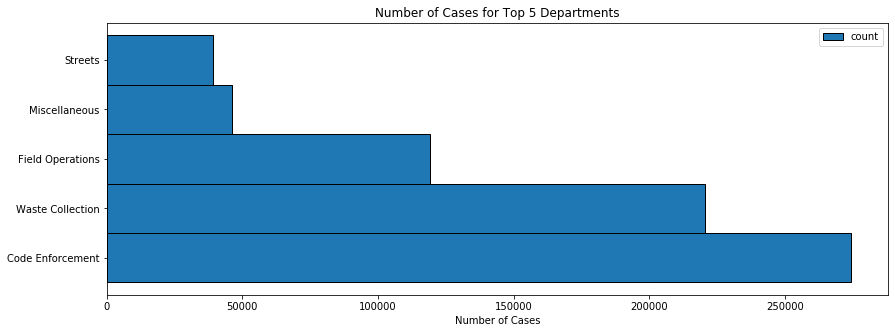

In [169]:
# Cases by department 
pdf = df.groupby(df.dept_division).count().sort('count',ascending=False).toPandas()
pdf.set_index('dept_division').head().plot.barh(width=1, edgecolor="black", figsize=(14, 5))
plt.title("Number of Cases for Top 5 Departments")
plt.ylabel("")
plt.xlabel("Number of Cases")

- Does the percentage of cases that are late vary by department?

- On average, how late are the late cases by department?

- What is the service type that is the most late? Just for Parks & Rec?

- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

- Does whether or not its a weekend matter for when a case is opened/closed?

- On average, how many cases are opened a day for the Customer Service department?

- Does the number of service requests for the solid waste department vary by day of the week?